# Patient Selection

# 1. Import Libraries and Load Data

## 1-1. Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
!pip install aequitas
import aequitas as ae

# helper functions
!from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.8/229.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 38.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of fairlearn to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.0 MB/s eta 0:00

/bin/bash: line 1: from: command not found


## 1-2. Load data



In [3]:
import pandas as pd
import time
from tabulate import tabulate

dataset_path = "/content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main/data/diabetes.csv"
print(dataset_path)

# Read the CSV file and calculate start time
start_time = time.time()
df = pd.read_csv(dataset_path)

# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(tabulate(df.head(10), headers='keys', tablefmt='pretty', showindex=False))

# Calculate and print the number of rows and columns
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# End time calculation
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)

# create a copy dataframe
df_copy = df.copy()

/content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main/data/diabetes.csv
First few rows of the DataFrame:
+-------------+---------+---------------+---------------+---------+------+--------------------------+------+---------+
| Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin | BMI  | DiabetesPedigreeFunction | Age  | Outcome |
+-------------+---------+---------------+---------------+---------+------+--------------------------+------+---------+
|     6.0     |  148.0  |     72.0      |     35.0      |   0.0   | 33.6 |          0.627           | 50.0 |   1.0   |
|     1.0     |  85.0   |     66.0      |     29.0      |   0.0   | 26.6 |          0.351           | 31.0 |   0.0   |
|     8.0     |  183.0  |     64.0      |      0.0      |   0.0   | 23.3 |          0.672           | 32.0 |   1.0   |
|     1.0     |  89.0   |     66.0      |     23.0      |  94.0   | 28.1 |          0.167           | 21.0 |   0.0   |
|     0.0     |  137.0  |   

## 1-3. Level of dataset

We need to confirm the level (line level, encounter level, or patient level) of our EHR datasets.

In [4]:
# number of distinct encounter ids
num_unique_encounters = df['encounter_id'].nunique()
print("Number of unique encounters: {}".format(num_unique_encounters))

# number of rows in the dataset
print("Total number of rows: {}".format(df.shape[0]))

if num_unique_encounters == df.shape[0]:
    print("Data is at the Encounter Level")
else:
    print("Data is at the Line Level")

KeyError: 'encounter_id'

In [ ]:
import time
from tabulate import tabulate

# Start time calculation
start_time = time.time()

# this code snippet searches for the first patient
# who has more than one encounter and prints the data of the first encounters for that patient.
for patient_id in df['patient_nbr'].unique():
    patient_df = df[df['patient_nbr']==patient_id]
    if patient_df['encounter_id'].nunique() > 1:
        break

# Print the first few rows of encounters for the selected patient
print("First few rows of encounters for the selected patient:")
print(tabulate(patient_df.head(), headers='keys', tablefmt='pretty', showindex=False))

# End time calculation
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the number of rows and columns
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# Print the duration in seconds and minutes
print("Duration in seconds:", duration_seconds)


First few rows of encounters for the selected patient:
+--------------+-------------+-----------+--------+---------+--------+-------------------+--------------------------+---------------------+------------------+------------+------------------------+------------------------+-----------------------+-------------------+------------------+------------------+--------------------+------------------+-----------------+----------------+-----------+---------------+-----------+--------+------------+
| encounter_id | patient_nbr |   race    | gender |   age   | weight | admission_type_id | discharge_disposition_id | admission_source_id | time_in_hospital | payer_code |   medical_specialty    | primary_diagnosis_code | other_diagnosis_codes | number_outpatient | number_inpatient | number_emergency | num_lab_procedures | number_diagnoses | num_medications | num_procedures | ndc_code  | max_glu_serum | A1Cresult | change | readmitted |
+--------------+-------------+-----------+--------+---------+--

The number of the unique encounter_ids is smaller than the total number of rows in the dataset. Therefore, the dataset is at the **line level**.

Besides `encounter_id` and `patient_nbr`, we should also group **all columns except the ndc_code columns** because those values are the same during the same encounter visit.

In [ ]:
import time
from tabulate import tabulate

# Assuming df is defined in your code
enc_cols = ['ndc_code']
enc_grps = [x for x in df.columns if x not in enc_cols]

# Start time calculation
start_time = time.time()

# Group into encounter level
enc_df = df.groupby(enc_grps)[enc_cols].agg(lambda x: list([y for y in x if y is not np.nan])).reset_index()

# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(tabulate(enc_df.head(), headers='keys', tablefmt='pretty', showindex=False))

# Print the number of rows and columns
num_rows, num_columns = enc_df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# End time calculation
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)


First few rows of the DataFrame:
+--------------+-------------+-----------------+--------+----------+--------+-------------------+--------------------------+---------------------+------------------+------------+-------------------+------------------------+-----------------------+-------------------+------------------+------------------+--------------------+------------------+-----------------+----------------+---------------+-----------+--------+------------+-----------------------------+
| encounter_id | patient_nbr |      race       | gender |   age    | weight | admission_type_id | discharge_disposition_id | admission_source_id | time_in_hospital | payer_code | medical_specialty | primary_diagnosis_code | other_diagnosis_codes | number_outpatient | number_inpatient | number_emergency | num_lab_procedures | number_diagnoses | num_medications | num_procedures | max_glu_serum | A1Cresult | change | readmitted |          ndc_code           |
+--------------+-------------+---------------

We can confirm that this is not at the encounter level because the total number of rows is equal to the number of unique encounter_ids.

In [ ]:
#These conditions are met if the number of rows in the DataFrame is equal to the number of unique values
# in the column "encounter_id". This implies that each value in the "encounter_id" column is unique,
# representing a distinct encounter.
enc_df.shape[0] == enc_df['encounter_id'].nunique()

True

# 2. Exploratory Data Analysis

## 2-1. Missing Values

To explore the distributions of the features, I created a copy of the dataset and replaced "?" with np.nan

In [ ]:
from tabulate import tabulate
import time

# Start time calculation
start_time = time.time()

# Assuming enc_df is defined in your code
df_eda = enc_df.copy()
df_eda = df_eda.replace(["?", "None"], np.nan)

# Print the first row of the DataFrame
print("First row of the DataFrame:")
print(tabulate(df_eda.head(10), headers='keys', tablefmt='pretty', showindex=False))

# Print the number of rows and columns
num_rows, num_columns = df_eda.shape
print("\nNumber of rows:", num_rows)
print("Number of columns:", num_columns)

# End time calculation
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)


First row of the DataFrame:
+--------------+-------------+-----------------+--------+----------+--------+-------------------+--------------------------+---------------------+------------------+------------+------------------------+------------------------+-----------------------+-------------------+------------------+------------------+--------------------+------------------+-----------------+----------------+---------------+-----------+--------+------------+-----------------------------------------+
| encounter_id | patient_nbr |      race       | gender |   age    | weight | admission_type_id | discharge_disposition_id | admission_source_id | time_in_hospital | payer_code |   medical_specialty    | primary_diagnosis_code | other_diagnosis_codes | number_outpatient | number_inpatient | number_emergency | num_lab_procedures | number_diagnoses | num_medications | num_procedures | max_glu_serum | A1Cresult | change | readmitted |                ndc_code                 |
+--------------+

From the cell below we see that:

1. `weight` (96.8%), `payer_code` (39.5%), `medical_specialty` (49%), `max_glu_serum` (94.7%), and `A1Cresult` (83.2%) have high amount of missing vallues.

2. `race` (2%) and `primary_diagnosis_code` (0.02%) have less missing values.

In [ ]:
na_df = pd.DataFrame(df_eda.isna().sum(), columns=['num_nas'])
na_df['Percentage'] = na_df['num_nas']/df_eda.shape[0]
# Set display options for printing
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

# Print the DataFrame with left alignment
na_df.style.set_properties(**{'text-align': 'left'})

<ipython-input-10-b72d20470d54>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,num_nas,Percentage
encounter_id,0,0.000000
patient_nbr,0,0.000000
race,2273,0.022336
gender,0,0.000000
age,0,0.000000
weight,98569,0.968585
admission_type_id,0,0.000000
discharge_disposition_id,0,0.000000
admission_source_id,0,0.000000
time_in_hospital,0,0.000000


## 2-2. Distribution of Numeric Columns

In [ ]:
import seaborn as sns

The distribution of `age` is not Gaussian. The `weight` distribution looks like Gaussian. However, the distribution is truncated below 0.

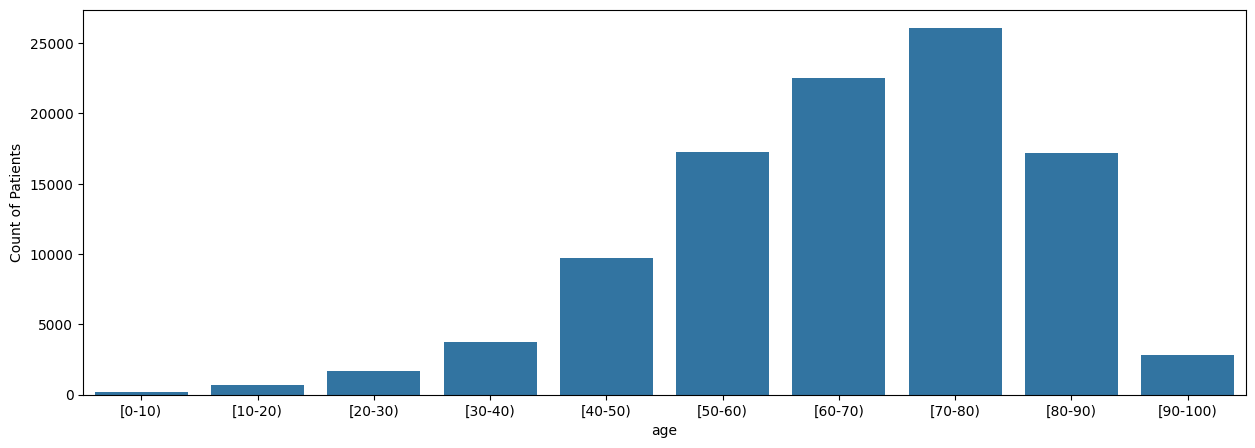

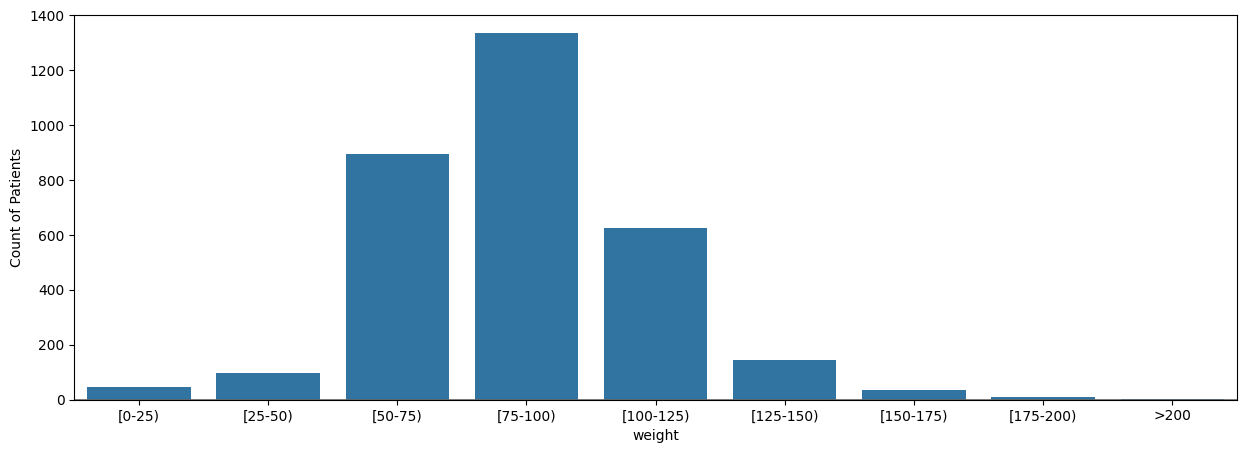

In [ ]:
# Distribution of Age and Weight
plt.figure(figsize=(15, 5))

# Distribution of Age
plt.subplot(1, 1, 1)
ax = sns.countplot(x="age", data=df_eda,
                   order=['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
                          '[60-70)', '[70-80)', '[80-90)', '[90-100)'])
ax.set_ylabel('Count of Patients')
plt.show()

print(" " * 20)
# Distribution of Weight
plt.figure(figsize=(15, 5))

plt.subplot(1, 1, 1)
ax = sns.countplot(x="weight", data=df_eda,
                   order=['[0-25)', '[25-50)', '[50-75)', '[75-100)', '[100-125)', '[125-150)',
                          '[150-175)', '[175-200)', '>200'])
ax.set_ylabel('Count of Patients')

# Add more visible horizontal lines between subplots
plt.axhline(y=0.5, color='black', linewidth=2, alpha=0.5)
plt.axhline(y=0.8, color='gray', linewidth=2, alpha=0.5)
plt.axhline(y=0.2, color='gray', linewidth=2, alpha=0.5)

plt.show()


From the histograms below, we see that `num_lab_procedures` looks like Gaussian (however there's a second peak close to 0).

On the other hand, `number_outpatient`, `number_inpatient`, `number_emergency`, `number_diagnoses`, `num_medications`, and `num_procedures` are not Gaussian distrubuted.

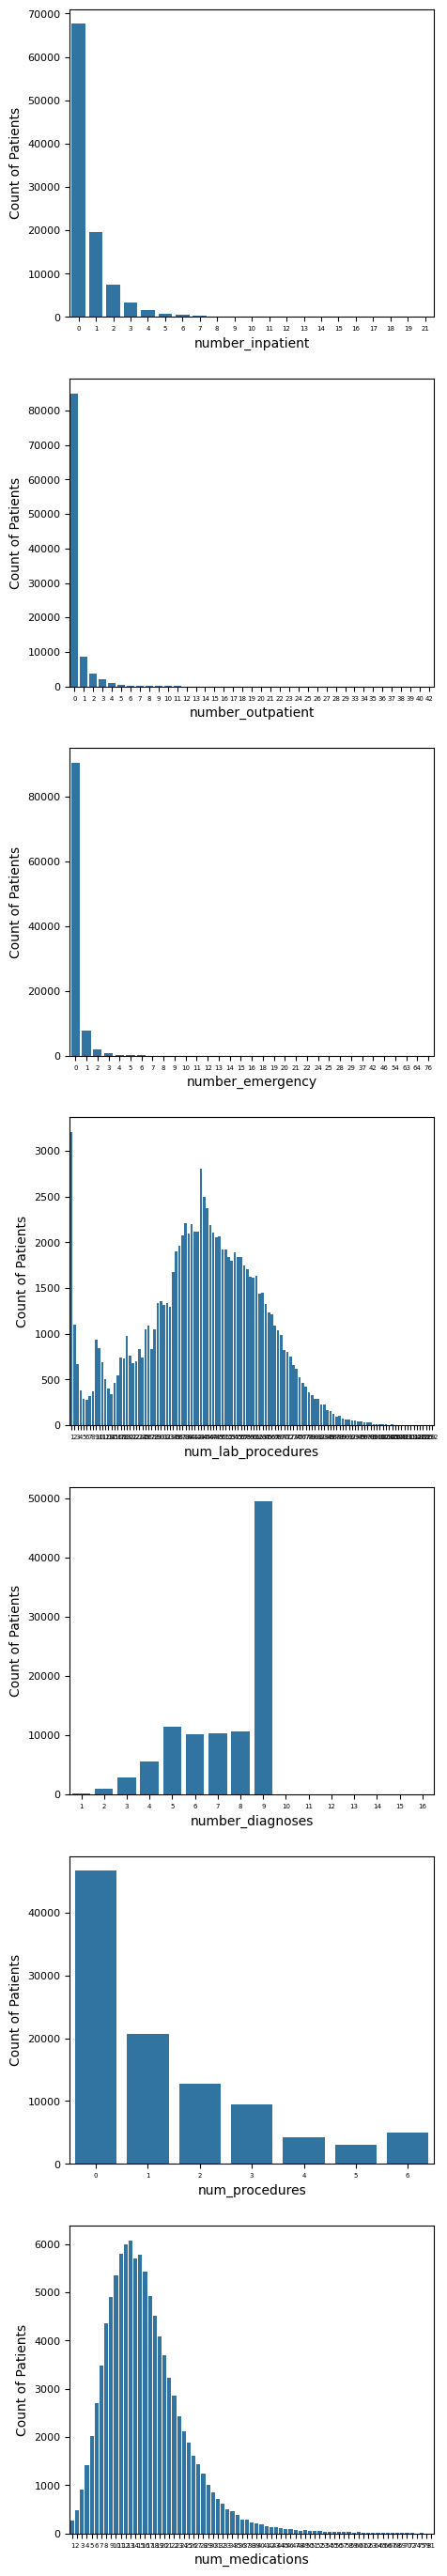

In [ ]:
plt.figure(figsize=(5, 40))

# distribution of number_inpatient
plt.subplot(8,1,1)
ax = sns.countplot(x="number_inpatient", data=df_eda)
ax.set_ylabel('Count of Patients')
ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce font size
ax.tick_params(axis='x', which='major', labelsize=5)  # Reduce font size on x-axis
# Draw a horizontal line at the end
plt.axhline(y=1, color='black', linewidth=0.5)  # Adjust line width

# distribution of number_outpatient
plt.subplot(8,1,2)
ax = sns.countplot(x="number_outpatient", data=df_eda)
ax.set_ylabel('Count of Patients')
ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce font size
ax.tick_params(axis='x', which='major', labelsize=5)  # Reduce font size on x-axis
# Draw a horizontal line at the end
plt.axhline(y=1, color='black', linewidth=0.5)  # Adjust line width

# distribution of number_emergency
plt.subplot(8,1,3)
ax = sns.countplot(x="number_emergency", data=df_eda)
ax.set_ylabel('Count of Patients')
ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce font size
ax.tick_params(axis='x', which='major', labelsize=5)  # Reduce font size on x-axis
# Draw a horizontal line at the end
plt.axhline(y=1, color='black', linewidth=0.5)  # Adjust line width

# distribution of num_lab_procedures
plt.subplot(8,1,4)
ax = sns.countplot(x="num_lab_procedures", data=df_eda)
ax.set_ylabel('Count of Patients')
ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce font size
ax.tick_params(axis='x', which='major', labelsize=5)  # Reduce font size on x-axis
# Draw a horizontal line at the end
plt.axhline(y=1, color='black', linewidth=0.5)  # Adjust line width

# distribution of number_diagnoses
plt.subplot(8,1,5)
ax = sns.countplot(x="number_diagnoses", data=df_eda)
ax.set_ylabel('Count of Patients')
ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce font size
ax.tick_params(axis='x', which='major', labelsize=5)  # Reduce font size on x-axis
# Draw a horizontal line at the end
plt.axhline(y=1, color='black', linewidth=0.5)  # Adjust line width

# distribution of num_procedures
plt.subplot(8,1,6)
ax = sns.countplot(x="num_procedures", data=df_eda)
ax.set_ylabel('Count of Patients')
ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce font size
ax.tick_params(axis='x', which='major', labelsize=5)  # Reduce font size on x-axis
# Draw a horizontal line at the end
plt.axhline(y=1, color='black', linewidth=0.5)  # Adjust line width

# distribution of num_medications
plt.subplot(8,1,7)
ax = sns.countplot(x="num_medications", data=df_eda)
ax.set_ylabel('Count of Patients')
ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce font size
ax.tick_params(axis='x', which='major', labelsize=5)  # Reduce font size on x-axis

plt.show()


For `max_glu_serum`, `A1Cresult`, and `readmitted`, there are only 3 distinct categories for each.

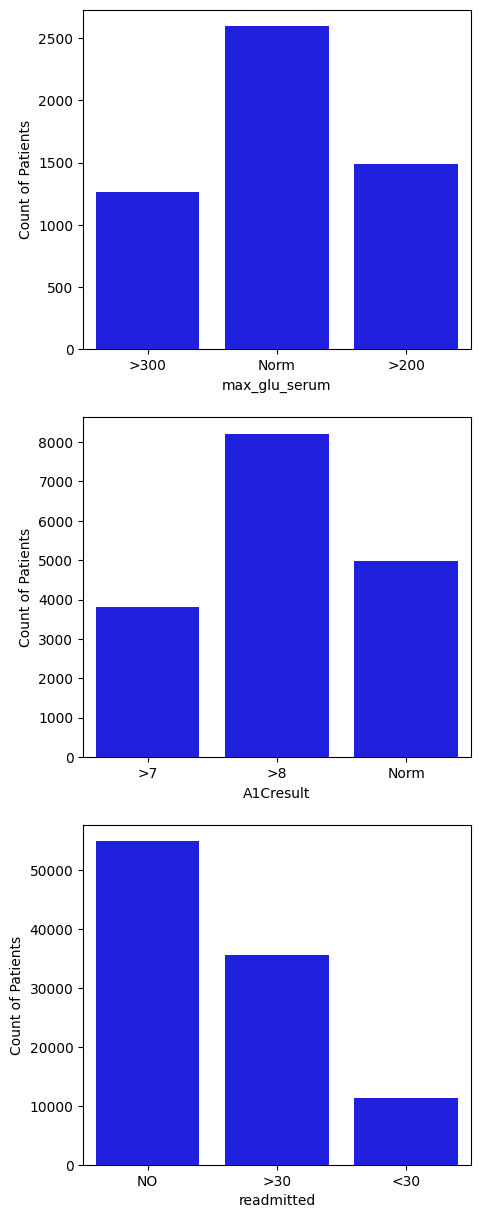

In [ ]:
plt.figure(figsize=(5,15))

# distribution of max_glu_serum
plt.subplot(3,1,1)
ax = sns.countplot(x="max_glu_serum", data=df_eda, color="blue" )
ax.set_ylabel('Count of Patients')


# distribution of A1Cresult
plt.subplot(3,1,2)
ax = sns.countplot(x="A1Cresult", data=df_eda, color="blue")
ax.set_ylabel('Count of Patients')

# distribution of readmitted
plt.subplot(3,1,3)
ax = sns.countplot(x="readmitted", data=df_eda, color="blue")
ax.set_ylabel('Count of Patients')

plt.show()

Finally, the distribution of `time_in_hospital` (the value we want to predict) is not a Gaussian.

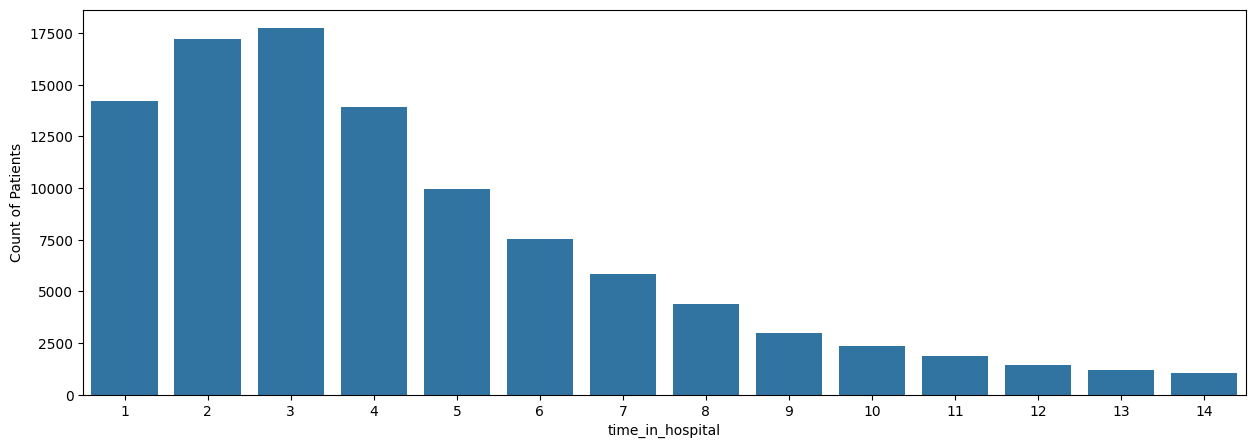

In [ ]:
# distribution of time_in_hospital
plt.figure(figsize=(15,5))
ax = sns.countplot(x="time_in_hospital", data=df_eda)
ax.set_ylabel('Count of Patients')

plt.show()

# 3. Data Processing

After understanding the data, we need to perform some processing for the following feature extraction. We will:

1. Reduce the dimensionality of the NDC code (dims=251) to (dims=24)

2. Reduce the number of rows by only selecting the first encounter of each patient

3. Aggregate the dataframe by patient ID


## 3-1. Reduce Dimensionality of the NDC Code

The dimensionality of the NDC codes can be reduced because the same drug can be represented by multiple codes.

In [ ]:
import pandas as pd
from tabulate import tabulate
import time

# Start time calculation
start_time = time.time()

# NDC code lookup file
ndc_code_path = "/content/drive/MyDrive/Patient-Selection-for-Diabetes-Drug-Testing-main/medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

# Print the first few rows of the DataFrame with left alignment
print("First few rows of the DataFrame:")
print(tabulate(ndc_code_df.head(), headers='keys', tablefmt='pretty'))

# Print the number of rows and columns
num_rows, num_columns = ndc_code_df.shape
print("\nNumber of rows:", num_rows)
print("Number of columns:", num_columns)

# End time calculation
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)


First few rows of the DataFrame:
+---+-----------+------------------+-------------------------+--------------------------+------------+------------------------------+-------------------------+
|   | NDC_Code  | Proprietary Name |  Non-proprietary Name   |       Dosage Form        | Route Name |         Company Name         |      Product Type       |
+---+-----------+------------------+-------------------------+--------------------------+------------+------------------------------+-------------------------+
| 0 | 0087-6060 |    Glucophage    | Metformin Hydrochloride |   Tablet, Film Coated    |    Oral    | Bristol-myers Squibb Company | Human Prescription Drug |
| 1 | 0087-6063 |  Glucophage XR   | Metformin Hydrochloride | Tablet, Extended Release |    Oral    | Bristol-myers Squibb Company | Human Prescription Drug |
| 2 | 0087-6064 |  Glucophage XR   | Metformin Hydrochloride | Tablet, Extended Release |    Oral    | Bristol-myers Squibb Company | Human Prescription Drug |
| 3 | 0

In [ ]:
print("Number of unique ndc_code: {}".format(df['ndc_code'].nunique()))
print("Number of unique non-proprietary names: {}".format(ndc_code_df['Non-proprietary Name'].nunique()))

Number of unique ndc_code: 251
Number of unique non-proprietary names: 24


In [ ]:
# check if every ndc_code (except np.nan) exists in final_ndc_lookup_table
for x in df['ndc_code'].astype('str').unique():
    if x not in ndc_code_df['NDC_Code'].unique():
        print("{} is not in final_ndc_lookup_table".format(x))

nan is not in final_ndc_lookup_table


In [ ]:
%cd /content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main

from student_utils import reduce_dimension_ndc

/content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main


In [ ]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [ ]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [ ]:

# Start time calculation
start_time = time.time()

# Assuming reduce_dim_df is defined in your code
# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(tabulate(reduce_dim_df.head(), headers='keys', tablefmt='pretty', showindex=False))

# Calculate and print the number of rows and columns
num_rows, num_columns = reduce_dim_df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# End time calculation
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)


First few rows of the DataFrame:
+--------------+-------------+-----------------+--------+---------+--------+-------------------+--------------------------+---------------------+------------------+------------+--------------------------+------------------------+-----------------------+-------------------+------------------+------------------+--------------------+------------------+-----------------+----------------+------------+---------------+-----------+--------+------------+-------------------+
| encounter_id | patient_nbr |      race       | gender |   age   | weight | admission_type_id | discharge_disposition_id | admission_source_id | time_in_hospital | payer_code |    medical_specialty     | primary_diagnosis_code | other_diagnosis_codes | number_outpatient | number_inpatient | number_emergency | num_lab_procedures | number_diagnoses | num_medications | num_procedures |  ndc_code  | max_glu_serum | A1Cresult | change | readmitted | generic_drug_name |
+--------------+-----------

In [ ]:
reduce_dim_df.shape

(143424, 27)

## 3-2. Select the First Encounter for Each Patient

For this project, we only use the data from the first encounter for each patient.

In [ ]:
from student_utils import select_first_encounter

first_encounter_df = select_first_encounter(reduce_dim_df)

In [ ]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


In [ ]:
print(first_encounter_df.shape)

(101754, 27)


## 3-3. Aggregate Dataframe

This code performs DataFrame aggregation. It first drops the column "ndc_code" from the DataFrame "first_encounter_df".

In [ ]:
# drop ndc_code
first_encounter_df = first_encounter_df.drop('ndc_code', axis=1)

In [ ]:
import utils

In [ ]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = utils.aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main/utils.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(grouping_field_list)['encounter_id',
/content/drive/MyDrive/Student_project/Patient-Selection-for-Diabetes-Drug-Testing-main/utils.py:21: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummy_df = pd.get_dummies(df[array_field + '_array'].apply(pd.Series).stack()).sum(level=0)


In [ ]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [ ]:
# show the list of generic drugs
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole_And_Metformin_Hydrochloride',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide',
 'nan']

In [ ]:
# inpect the data after aggregation
import time
import pandas as pd
from tabulate import tabulate

# Start time calculation
start_time = time.time()

# Assuming agg_drug_df is defined in your code
# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(tabulate(agg_drug_df.head(), headers='keys', tablefmt='pretty', showindex=False))

# Calculate and print the number of rows and columns
num_rows, num_columns = agg_drug_df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# End time calculation
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)


First few rows of the DataFrame:
+--------------+-------------+-----------------+--------+----------+--------+-------------------+--------------------------+---------------------+------------------+------------+-------------------+------------------------+-----------------------+-------------------+------------------+------------------+--------------------+------------------+-----------------+----------------+---------------+-----------+--------+------------+--------------------------------------------+----------+-------------+-----------+-----------------------------+---------------------------------------+-----------+---------------------------------------+-----------------------------------+---------------+---------------+---------------+-------------------------+----------+-------------+------------------------------------------+--------------+--------------------------------------------+-------------+-----------------------+------------+-------------+-----+
| encounter_id | patien

The dataset is now ready for feature selection.

# 4. Feature Selection and Engineering




Distribution of the availble weight data:


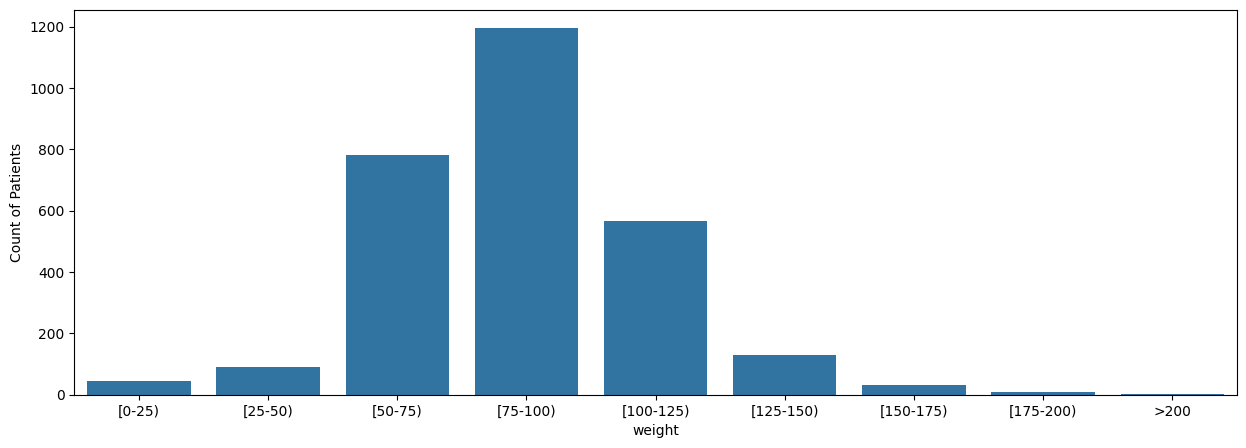

ratio of missing values of weights = 0.960107944853044


In [ ]:
# analysis of the weight data
plt.figure(figsize=(15,5))
weights_data = agg_drug_df['weight'].tolist()
print("\nDistribution of the availble weight data:")
ax = sns.countplot(x="weight", data=agg_drug_df,
                   order=['[0-25)','[25-50)','[50-75)','[75-100)','[100-125)','[125-150)',
                          '[150-175)', '[175-200)', '>200'])
ax.set_ylabel('Count of Patients')
plt.show()
print("ratio of missing values of weights = {}".format(weights_data.count('?')/len(weights_data)))

In [ ]:
# required columns (Udacity)
required_demo_col_list = ['race', 'gender', 'age']

# selected categorical columns (excluding ndc drugs)

student_categorical_col_list = ['admission_source_id', 'max_glu_serum', 'A1Cresult'] + required_demo_col_list + ndc_col_list

# selected numerical columns
student_numerical_col_list = ['num_medications', 'num_lab_procedures']

PREDICTOR_FIELD = 'time_in_hospital'

In [ ]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):

    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list

    return agg_drug_df[selected_col_list]

In [ ]:
selected_features_df = select_model_features(agg_drug_df,
                                             student_categorical_col_list,
                                             student_numerical_col_list,
                                             PREDICTOR_FIELD)

In [ ]:
# see the dataframe with selected features

# Start time calculation
start_time = time.time()

# Assuming selected_features_df is defined in your code
# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(tabulate(selected_features_df.head(), headers='keys', tablefmt='pretty', showindex=False))

# Calculate and print the number of rows and columns
num_rows, num_columns = selected_features_df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# End time calculation
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)


First few rows of the DataFrame:
+-------------+------------------+---------------------+---------------+-----------+-----------------+--------+----------+----------+-------------+-----------+-----------------------------+---------------------------------------+-----------+---------------------------------------+-----------------------------------+---------------+---------------+---------------+-------------------------+----------+-------------+------------------------------------------+--------------+--------------------------------------------+-------------+-----------------------+------------+-------------+-----+-----------------+--------------------+
| patient_nbr | time_in_hospital | admission_source_id | max_glu_serum | A1Cresult |      race       | gender |   age    | Acarbose | Glimepiride | Glipizide | Glipizide_And_Metformin_Hcl | Glipizide_And_Metformin_Hydrochloride | Glyburide | Glyburide_And_Metformin_Hydrochloride | Glyburide-metformin_Hydrochloride | Human_Insulin | Ins

## 4-2. Impute Numerical Features by Zeros

The code aims to process the input DataFrame using this information and perform appropriate operations such as handling missing values and converting categorical columns into numerical ones for use in analysis or prediction tasks.

In [ ]:
processed_df = utils.preprocess_df(selected_features_df.copy(),
                             student_categorical_col_list,
                             student_numerical_col_list,
                             PREDICTOR_FIELD,
                             categorical_impute_value='nan',
                             numerical_impute_value=0)


## 4-3. Split Data

We split the data into 60% training dataset, 20% validation dataset, and 20% test dataset. After split, we confirm that there's not data leakage between the partitions.

In [ ]:
import student_utils
#from student_utils import patient_dataset_splitter

d_train, d_val, d_test = student_utils.patient_dataset_splitter(processed_df, 'patient_nbr')

In [ ]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [ ]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## 4-4. Demographic Representation Analysis of Split

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0     9567 
5.0     6839 
6.0     5171 
7.0     3999 
8.0     2919 
9.0     1990 
10.0    1558 
11.0    1241 
12.0    955  
13.0    795  
14.0    669  
dtype: int64
Axes(0.125,0.11;0.775x0.77)


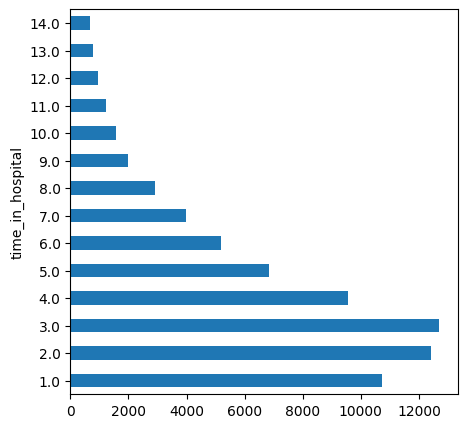

In [ ]:
plt.figure(figsize=(5,5))
utils.show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6440
2.0     7327
3.0     7537
4.0     5805
5.0     4113
6.0     3127
7.0     2398
8.0     1753
9.0     1196
10.0    955 
11.0    772 
12.0    586 
13.0    490 
14.0    411 
dtype: int64
Axes(0.125,0.11;0.775x0.77)


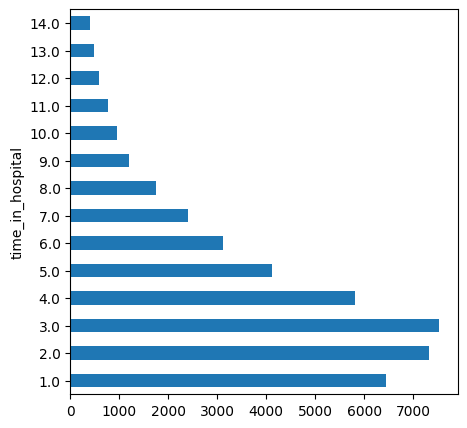

In [ ]:
plt.figure(figsize=(5,5))
utils.show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2174
2.0     2507
3.0     2548
4.0     1880
5.0     1368
6.0     1030
7.0     819 
8.0     586 
9.0     409 
10.0    291 
11.0    248 
12.0    185 
13.0    134 
14.0    125 
dtype: int64
Axes(0.125,0.11;0.775x0.77)


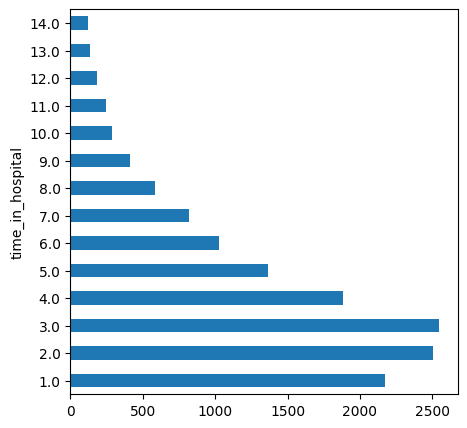

In [ ]:
plt.figure(figsize=(5,5))
utils.show_group_stats_viz(d_test, PREDICTOR_FIELD)

gender
Female             38025
Male               33490
Unknown/Invalid    3    
dtype: int64
Axes(0.125,0.11;0.775x0.77)


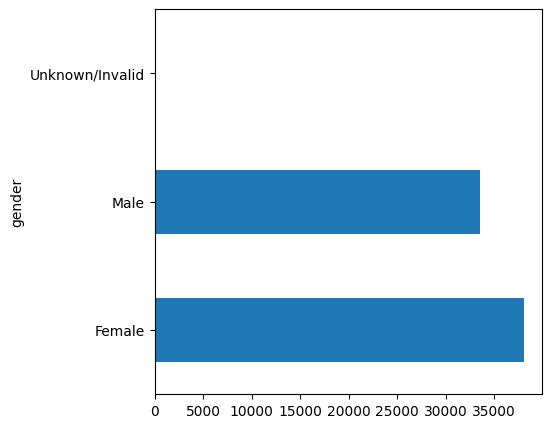

In [ ]:
# Full dataset before splitting
plt.figure(figsize=(5,5))
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
utils.show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22804
Male               20103
Unknown/Invalid    3    
dtype: int64
Axes(0.125,0.11;0.775x0.77)


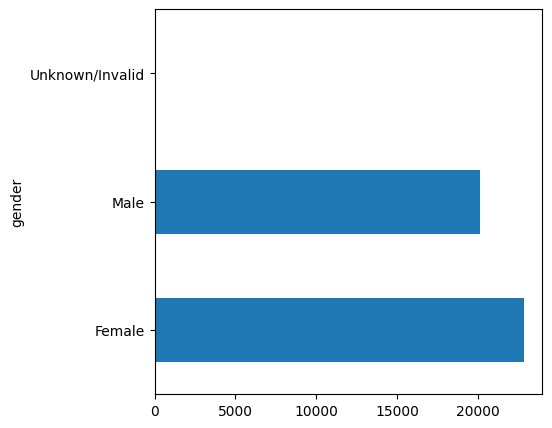

In [ ]:
# Training partition
plt.figure(figsize=(5,5))
utils.show_group_stats_viz(d_train, 'gender')

gender
Female    7630
Male      6674
dtype: int64
Axes(0.125,0.11;0.775x0.77)


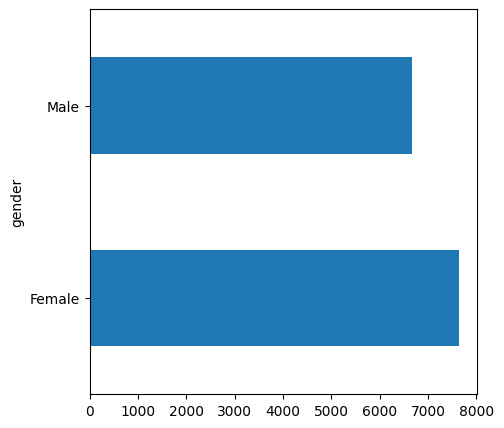

In [ ]:
# Test partition
plt.figure(figsize=(5,5))
utils.show_group_stats_viz(d_test, 'gender')

## 4-5. Convert Dataset to TF Dataset

In [ ]:
# convert dataset from Pandas dataframes to TF dataset
batch_size = 128
diabetes_train_ds = utils.df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = utils.df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = utils.df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

These messages are notifications indicating that the vocabulary size for some features has been inferred based on the number of elements in the corresponding vocabulary file.

In [ ]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

## 4-6. Create Categorical Features with TF Feature Columns

In [ ]:
# we adding the directory
#!mkdir diabetes_vocab
vocab_file_list = utils.build_vocab_files(d_train, student_categorical_col_list)

In [ ]:
# view the list of vocab files
vocab_file_list

['./diabetes_vocab/admission_source_id_vocab.txt',
 './diabetes_vocab/max_glu_serum_vocab.txt',
 './diabetes_vocab/A1Cresult_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Human_Insulin_vocab.txt',
 './diabetes_vocab/Insulin_Human_vocab.txt',
 './diabetes_vocab/Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Miglitol_vocab.txt',
 './diabetes_vocab/Nateglinide_vocab.txt',
 './diabetes_vocab/Pioglitazole_And_Metformin_Hydrochl

In [ ]:
from student_utils import create_tf_categorical_feature_cols

# Replace 'student_utils' with 'utils' assuming that's the correct import
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


## 4-7. Create Numerical Features

In [ ]:
for col in student_numerical_col_list:
    d_train[col] = d_train[col].astype('float32')
    d_val[col] = d_val[col].astype('float32')
    d_test[col] = d_test[col].astype('float32')

<ipython-input-53-3da7b736f164>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_train[col] = d_train[col].astype('float32')
<ipython-input-53-3da7b736f164>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_val[col] = d_val[col].astype('float32')
<ipython-input-53-3da7b736f164>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
import student_utils
import functools
from student_utils import normalize_numeric_with_zscore, create_tf_numeric_feature

In [ ]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [ ]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


## 4-8. Combine Features with DenseFeatures

In [ ]:
# concatenate categorical and numeric feature columns
claim_feature_columns = tf_cat_col_list + tf_cont_col_list

# combine with TF DenseFeatures
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

# 5. Build and Train the Model

The model is built with DenseFeatures and TF Probability Layers. The optimizer used is rmsprop. We train the model for 10 epochs.

In [ ]:
import tensorflow as tf

In [ ]:
# Choose the distribution strategy
strategy = tf.distribute.MirroredStrategy()

def build_sequential_model(feature_layer):
    """
    Build model
    Args:
        feature_layer - feature layers created by TF DenseFeatures
    Output:
        model - the TF model
    """
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(512),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Dropout(0.5),  # Increase dropout for regularization
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Dropout(0.5),  # Increase dropout for regularization
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Dropout(0.5),  # Increase dropout for regularization
        tf.keras.layers.BatchNormalization(),
        tfp.layers.DenseVariational(1+1, utils.posterior_mean_field, utils.prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(loc=t[..., :1],
                                                scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))
    ])
    return model

def build_diabetes_model(train_ds, val_ds, feature_layer, epochs=10, loss_metric='mse', learning_rate=0.001, decision_threshold=0.1):
    """
    Train the model
    Args:
        train_ds - the training dataset
        val_ds - the validation dataset
        feature_layer - feature layers created by TF DenseFeatures
        epochs - number of epochs (default=10)
        loss_metric - the loss function (default=MSE)
        learning_rate - learning rate for optimization (default=0.001)
        decision_threshold - decision threshold for classification (default=0.1)
    Outputs:
        model - the trained model
        history - history of the metrics
    """

    # Build the model within the distribution strategy scope
    with strategy.scope():
        # build the model
        model = build_sequential_model(feature_layer)

        # compile the model
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=loss_metric, metrics=[loss_metric])

        # early stop callback
        early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)

        # train the model
        history = model.fit(train_ds, validation_data=val_ds, callbacks=[early_stop], epochs=epochs)

    return model, history


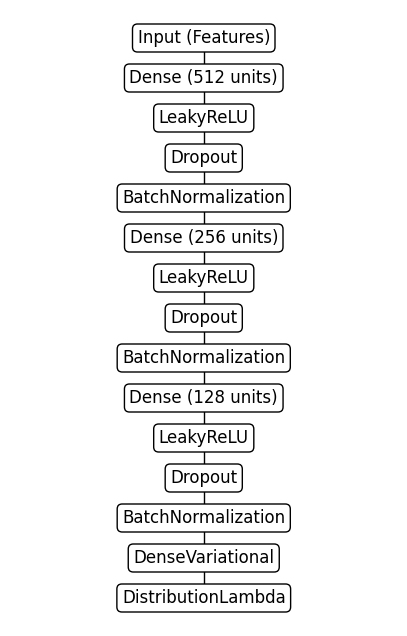

In [ ]:
import matplotlib.pyplot as plt

# Define the layers of the neural network in reversed order
layers = [
    "DistributionLambda",
    "DenseVariational",
    "BatchNormalization",
    "Dropout",
    "LeakyReLU",
    "Dense (128 units)",
    "BatchNormalization",
    "Dropout",
    "LeakyReLU",
    "Dense (256 units)",
    "BatchNormalization",
    "Dropout",
    "LeakyReLU",
    "Dense (512 units)",
    "Input (Features)"
]

# Set the figure size with width 5
plt.figure(figsize=(5, 8))

# Define the x and y positions for nodes
x_positions = [0.5] * len(layers)
y_positions = list(range(len(layers)))

# Plot the neural network
for i, (layer, x, y) in enumerate(zip(layers, x_positions, y_positions)):
    # Draw the node
    plt.text(x, y, layer, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Draw the connection line
    if i > 0:
        plt.plot([x_positions[i-1], x], [y_positions[i-1], y], color='black', linestyle='-', linewidth=1)

# Remove axis
plt.axis('off')

# Show the plot
plt.show()


summary of the main layers used in the model:
  
    1- Input (Features):
        Represents the input variables or features.
    2- Dense (512 units):
        Fully connected layer for learning complex patterns.
    3- LeakyReLU:
        Activation function introducing non-linearity, preventing dead neurons.
    4- Dropout:
        Prevents overfitting by randomly ignoring some units during training.
    5- BatchNormalization:
        Normalizes input distributions, speeding up training and reducing vanishing gradients.
    6- Dense (256 units):
        Another fully connected layer for learning.
    7- LeakyReLU:
        Linear activation function similar to before.
    8- Dropout:
        Used to prevent overfitting.
    9- BatchNormalization:
        Normalizes input distributions again.
    10- Dense (128 units):
        Another fully connected layer for deeper learning.
    11- DenseVariational:
        A layer allowing for variable units, expressing output distribution probabilities.
    12- DistributionLambda:
        Converts output into a probability distribution based on variable units, specifying potential outcome distributions.

Train for 336 steps": Means that the model is being trained using 336 training steps, where the model's weights are updated after each step.

"Validate for 112 steps": Means that the model's performance is being assessed using a validation set that the model has not been trained on. The performance is measured after every 112 steps.

"epochs=30" means that the model will be trained on the dataset for 30 complete passes.

In [ ]:
#Parallel
# Record the start time of the training
import time
start_time = time.time()

# Build and train the model
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, claim_feature_layer, epochs=20)

# Record the end time of the training
end_time = time.time()

# Calculate the training time in seconds
training_time_seconds = end_time - start_time

# Calculate the training time in minutes and seconds
training_time_minutes = training_time_seconds / 60

# Print the training time
print("Training time: {:.2f} seconds".format(training_time_seconds))
print("Training time: {:.2f} minutes".format(training_time_minutes))


Epoch 1/20
336/336 [==============================] - 17s 33ms/step - loss: 128.9084 - mse: 128.6176 - val_loss: 36.7255 - val_mse: 35.8832
Epoch 2/20
336/336 [==============================] - 8s 23ms/step - loss: 87.0779 - mse: 85.7748 - val_loss: 34.8661 - val_mse: 33.1519
Epoch 3/20
336/336 [==============================] - 10s 25ms/step - loss: 61.4772 - mse: 59.0883 - val_loss: 25.9005 - val_mse: 23.1670
Epoch 4/20
336/336 [==============================] - 12s 33ms/step - loss: 41.0614 - mse: 38.1312 - val_loss: 20.3867 - val_mse: 17.1441
Epoch 5/20
336/336 [==============================] - 10s 28ms/step - loss: 27.5987 - mse: 24.6966 - val_loss: 14.7415 - val_mse: 12.0785
Epoch 6/20
336/336 [==============================] - 9s 24ms/step - loss: 19.5855 - mse: 17.2068 - val_loss: 12.8907 - val_mse: 10.6134
Epoch 7/20
336/336 [==============================] - 10s 27ms/step - loss: 14.1878 - mse: 12.5062 - val_loss: 10.4542 - val_mse: 9.1466
Epoch 8/20
336/336 [===============

fluctuations in validation MSE during training can be due to changes in dataset composition, data irregularities, model parameter tuning, random sampling effects, and environmental or noise effects. These factors interact to influence model performance across epochs.

# 6. Results

## 6-1. Uncertainty of Model Prediction

We use TF Probability Layer to build the model. As a result, we can extract the mean and standard deviation for each prediction the model made.

In [ ]:
# list of columns used as features
feature_list = student_categorical_col_list + student_numerical_col_list
#
diabetes_x_tst = dict(d_test[feature_list])
#
diabetes_yhat = diabetes_model(diabetes_x_tst)

# predict on the test dataset
preds = diabetes_model.predict(diabetes_test_ds)

112/112 [==============================] - 3s 9ms/step


In [ ]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

In [ ]:
# create a dict for building the dataframe
prob_outputs = {"pred": preds.flatten(),
                "actual_value": d_test['time_in_hospital'].values,
                "pred_mean": m.numpy().flatten(),
                "pred_std": s.numpy().flatten()}

# convert prob_outputs into a dataframe
prob_output_df = pd.DataFrame(prob_outputs)

In [ ]:
# check the results
# Start time calculation
start_time = time.time()

# Assuming selected_features_df is defined in your code
# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(tabulate(selected_features_df.head(), headers='keys', tablefmt='pretty', showindex=False))

# Calculate and print the number of rows and columns
num_rows, num_columns = selected_features_df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# End time calculation
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)


First few rows of the DataFrame:
+-------------+------------------+---------------------+---------------+-----------+-----------------+--------+----------+----------+-------------+-----------+-----------------------------+---------------------------------------+-----------+---------------------------------------+-----------------------------------+---------------+---------------+---------------+-------------------------+----------+-------------+------------------------------------------+--------------+--------------------------------------------+-------------+-----------------------+------------+-------------+-----+-----------------+--------------------+
| patient_nbr | time_in_hospital | admission_source_id | max_glu_serum | A1Cresult |      race       | gender |   age    | Acarbose | Glimepiride | Glipizide | Glipizide_And_Metformin_Hcl | Glipizide_And_Metformin_Hydrochloride | Glyburide | Glyburide_And_Metformin_Hydrochloride | Glyburide-metformin_Hydrochloride | Human_Insulin | Ins

## 6-2. Patient Selection

We use the mean of the prediction to perform binary classification on each patients.

In [ ]:
from student_utils import get_student_binary_prediction

student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

In [ ]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    """
    Create a dataframe for the test dataset with 'score' and 'label_value'.
    'score' is the binary prediction that a patient would spend >= 5 days in the hospital
    'label_value' is the ground truth that a patient spent >= 5 days in the hospital
    Args:
        test_df - the test dataset
        pred_np - the binary prediction of the test dataset by the model
        demo_col_list: the categorical feature names
    Output:
        test_df - dataframe of the test dataset (with score and label_value)
    """

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    test_df = test_df.copy()

    # convert all values of the categorical columns into strings
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)

    # model binary prediction
    test_df['score'] = pred_np

    # actual labels
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >= 5 else 0)

    return test_df

# Use the modified function
pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])


In [ ]:
# Start time calculation
start_time = time.time()

# Assuming pred_test_df is defined in your code
# Print the selected columns of the first few rows of the DataFrame
print("Selected columns of the first few rows of the DataFrame:")
print(tabulate(pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head(), headers='keys', tablefmt='pretty', showindex=False))

# End time calculation
end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time

# Print the duration in seconds
print("Duration in seconds:", duration_seconds)


Selected columns of the first few rows of the DataFrame:
+-------------+--------+-----------------+------------------+-------+-------------+
| patient_nbr | gender |      race       | time_in_hospital | score | label_value |
+-------------+--------+-----------------+------------------+-------+-------------+
|  42519267   |  Male  |    Caucasian    |       1.0        |   0   |      0      |
|  82637451   |  Male  |    Caucasian    |       3.0        |   0   |      0      |
|  85504905   | Female |    Caucasian    |       7.0        |   0   |      1      |
|  86047875   | Female | AfricanAmerican |       2.0        |   0   |      0      |
|  108662661  | Female |    Caucasian    |       3.0        |   0   |      0      |
+-------------+--------+-----------------+------------------+-------+-------------+
Duration in seconds: 0.03337669372558594


# 7. Model Evaluation

## 7-1. Precision and Recall

Precision is the ratio of the number of true positives to the sum of the true positives and false positives. Recall is the ratio of the number of true positives to the sum of the true positives and false negatives. There's a tradeoff between them. If we increase the precision (we say no to the data that we're less confident in classifying as positive), we will classfy more true positives as negative and as a result decreasing the recall. On the other hand, if we increase the recall (by saying yes to the data that we're less confident in classifying it as as negative), we will calssify more true negative data as positive and as a result decreasing the precision.

To further improve the model's performance, we could focus on enhancing the recall without significantly sacrificing precision. One approach could be to adjust the classification threshold to favor sensitivity over specificity, thereby increasing the likelihood of capturing more positive cases. Additionally, we might explore feature engineering techniques to extract more relevant information from the data, which could potentially improve the model's ability to identify positive cases. Moreover, experimenting with different algorithms or model architectures might yield better results. Finally, incorporating techniques such as ensemble learning or model stacking could also help in boosting performance by combining the strengths of multiple models.

In [ ]:
from tabulate import tabulate
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

y_true = pred_test_df['label_value']
y_pred = pred_test_df['score']

# AUC, F1, precision and recall
# Summary

auc = roc_auc_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Metric': ['AUC', 'F1 score', 'Precision', 'Recall'],
    'Value': [auc, f1, precision, recall]
})

# Convert DataFrame to a list of lists for tabulate
results_list = results_df.values.tolist()

# Print the results using tabulate
print(tabulate(results_list, headers=['Metric ', 'Value'], tablefmt='pretty'))


+-----------+--------------------+
|  Metric   |       Value        |
+-----------+--------------------+
|    AUC    | 0.6802963699927231 |
| F1 score  | 0.7253918898821788 |
| Precision | 0.7513830133420111 |
|  Recall   | 0.4444658325312801 |
+-----------+--------------------+


<Figure size 500x1500 with 0 Axes>

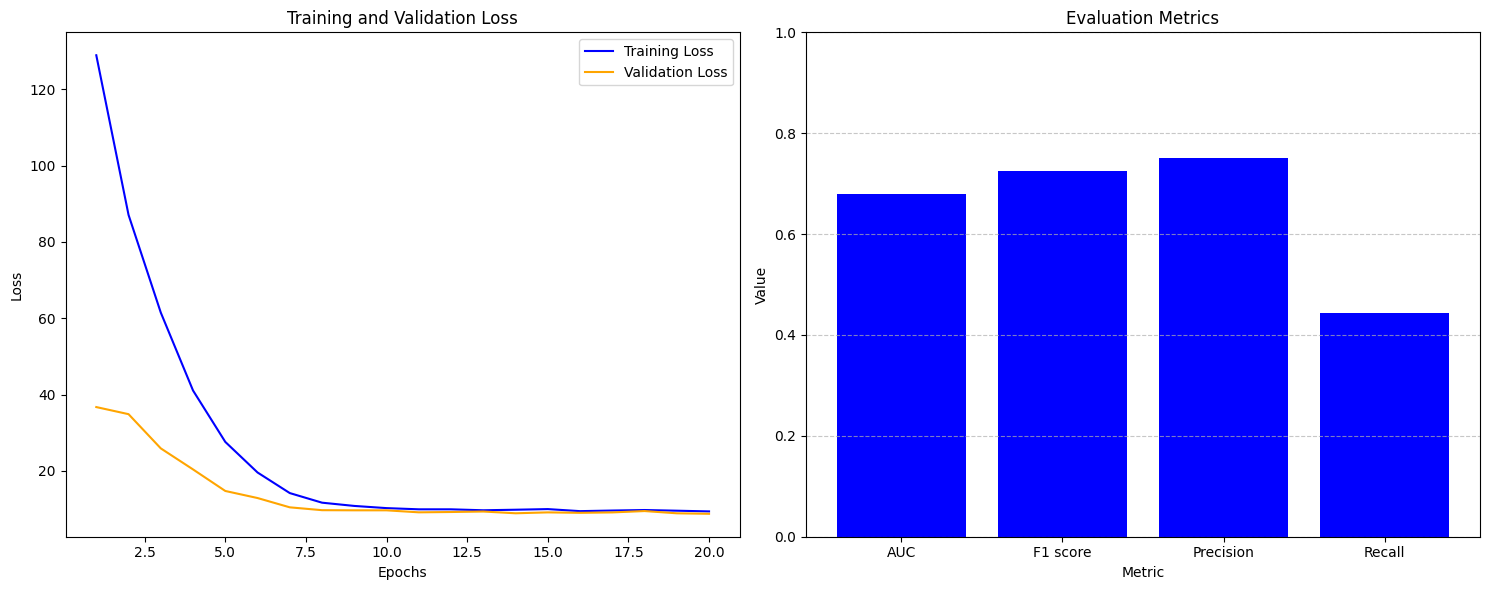

In [ ]:
plt.figure(figsize=(5,15))
import matplotlib.pyplot as plt

# Extract loss history from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract performance metrics from the results DataFrame
metrics = results_df['Metric']
values = results_df['Value']

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot training and validation loss
axes[0].plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
axes[0].plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot evaluation metrics
axes[1].bar(metrics, values, color=['blue', 'blue', 'blue', 'blue'])
axes[1].set_title('Evaluation Metrics')
axes[1].set_xlabel('Metric')
axes[1].set_ylabel('Value')
axes[1].set_ylim(0, 1)  # Setting y-axis limit to better visualize AUC
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import cohen_kappa_score
import pandas as pd

# Assuming y_true and y_pred are defined elsewhere in your code
# Calculate the Kappa score between the predictions and the actual data
kappa = cohen_kappa_score(y_true, y_pred)

# Define the levels of kappa
kappa_levels = {
    'Excellent': (0.81, 1.0),
    'Very Good': (0.61, 0.8),
    'Good': (0.41, 0.6),
    'Fair': (0.21, 0.409),
    'Poor': (0.0, 0.2)
}

# Determine the level of the kappa score
level = None
for category, (lower, upper) in kappa_levels.items():
    if lower <= kappa <= upper:
        level = category
        break

# Create a DataFrame to display the kappa score and its level
results = pd.DataFrame({
    "Metric": ["Kappa Score"],
    "Value": [kappa],
    "Level": [level]
})

# Print the results using tabulate
from tabulate import tabulate
print(tabulate(results, headers="keys", tablefmt="pretty"))


+---+-------------+--------------------+-------+
|   |   Metric    |       Value        | Level |
+---+-------------+--------------------+-------+
| 0 | Kappa Score | 0.3952812954983079 | Fair  |
+---+-------------+--------------------+-------+


 The levels of results that can be obtained, they are as follows:

    Excellent: If the Kappa score value is between 0.81 and 1.0.
    Very Good: If the Kappa score value is between 0.61 and 0.8.
    Good: If the Kappa score value is between 0.41 and 0.6.
    Fair: If the Kappa score value is between 0.21 and 0.4.
    Poor: If the Kappa score value is between 0.0 and 0.2.

These levels assess the degree of agreement between predictions and actual data, where higher Kappa values indicate better agreement between data and predictions.


## 7-2. Biases



In [ ]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness


ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)

g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)

aqp = Plot()
b = Bias()

In [ ]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab,
                                        original_df=ae_df,
                                        ref_groups_dict={'race':'Caucasian', 'gender':'Male'},
                                        alpha=0.05,
                                        check_significance=False)

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

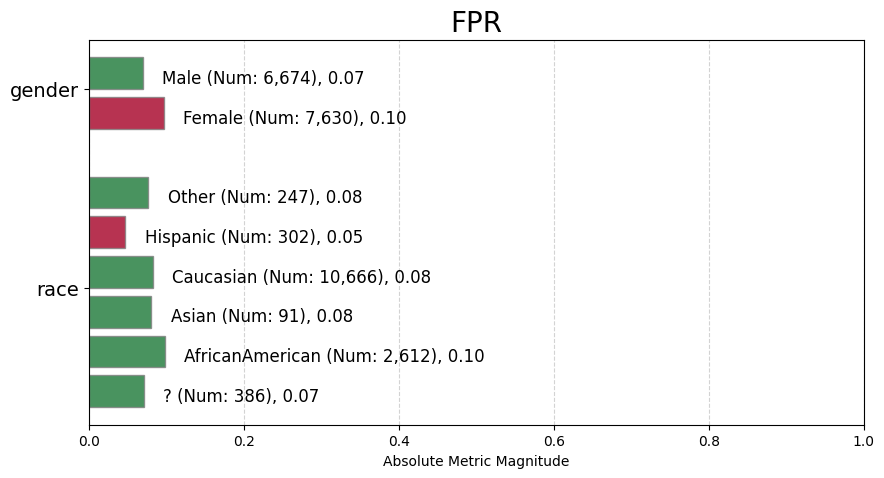

In [ ]:
# fairness: false positive rate
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

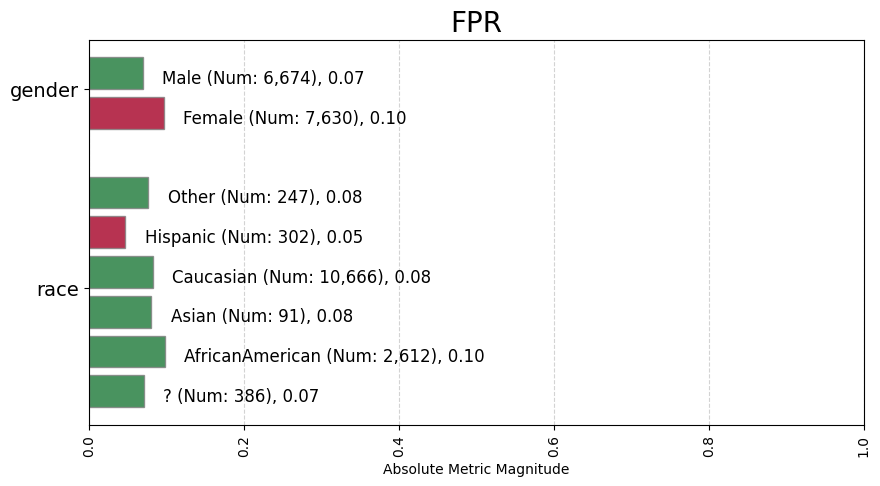

In [ ]:
import matplotlib.pyplot as plt

fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

#
plt.xticks(rotation=90)

plt.show()





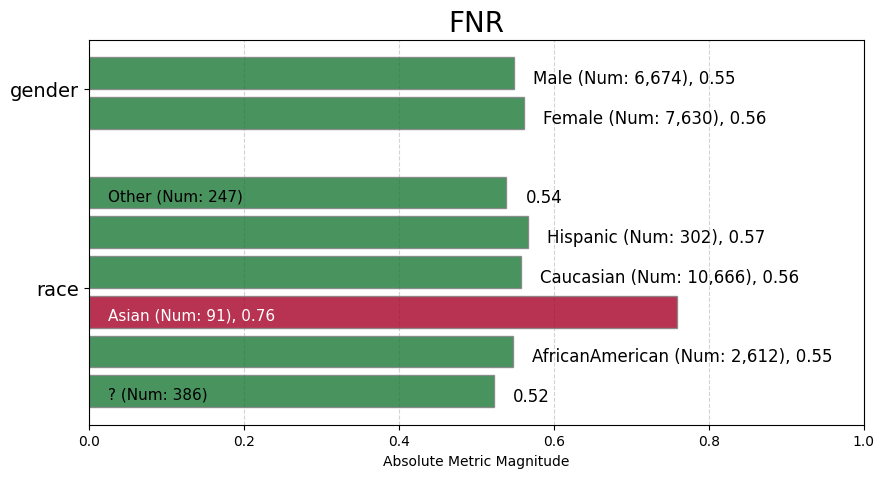

In [ ]:
# fairness: false negative rate
fnr_fairness = aqp.plot_fairness_group(fdf, group_metric='fnr', title=True)

## 7-3. Disparity

From the figures below we see that compared to Caucasian (the reference group), all other races have a higher false positive rate.

On the other hand, we don't see this in gender. Gender doesn't not have much influence on the false positive rate.

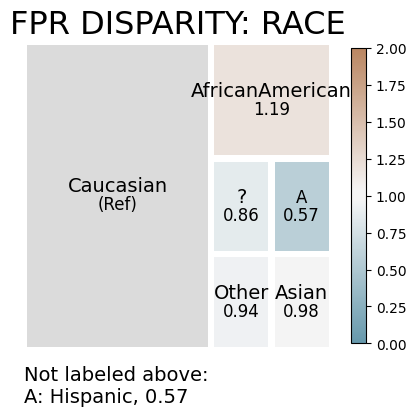

In [ ]:
# FPR disparity of race
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')

If the false positive rate (FPR) is lower, it means the model is better at classifying negative samples correctly as negatives, indicating better performance in predicting negative outcomes. Therefore, if the value is lower (such as 0.87), it signifies better performance compared to a higher value (like 1.96), hence the value 0.87 is better.

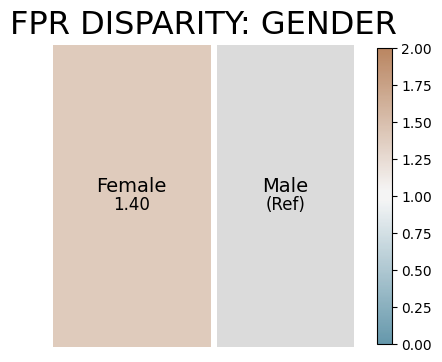

In [ ]:
# FPR disparity of gender
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='gender')